# Gaussian Mixed Model

In [1]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        reg_cov  = 1e-6
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            self.sigma[i] += reg_cov

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

# Bài tự thực hành 1

In [2]:
from sklearn.datasets import load_iris
X = load_iris().data
print(X.shape)
init_mu = X[np.random.choice(X.shape[0], 2, replace=False)]
init_sigma = np.zeros((2, 4, 4))
global_cov = np.cov(X, rowvar=False)
for i in range(2):
  init_sigma[i] = global_cov.copy()
gmm_iris = GMM(k = 2, dim=4, init_mu=init_mu, init_sigma=init_sigma)


(150, 4)


In [3]:
gmm_iris.init_em(X)
its = 50
log_likelihoods = [gmm_iris.log_likelihood(X)]
for e in range(its):
    # E-step
    gmm_iris.e_step()
    # M-step
    gmm_iris.m_step()
    # Computing log-likelihood
    log_likelihoods.append(gmm_iris.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihoods[-1]))



Iteration: 1, log-likelihood: -318.9326
Iteration: 2, log-likelihood: -282.4486
Iteration: 3, log-likelihood: -252.7920
Iteration: 4, log-likelihood: -214.5800
Iteration: 5, log-likelihood: -214.3547
Iteration: 6, log-likelihood: -214.3547
Iteration: 7, log-likelihood: -214.3547
Iteration: 8, log-likelihood: -214.3547
Iteration: 9, log-likelihood: -214.3547
Iteration: 10, log-likelihood: -214.3547
Iteration: 11, log-likelihood: -214.3547
Iteration: 12, log-likelihood: -214.3547
Iteration: 13, log-likelihood: -214.3547
Iteration: 14, log-likelihood: -214.3547
Iteration: 15, log-likelihood: -214.3547
Iteration: 16, log-likelihood: -214.3547
Iteration: 17, log-likelihood: -214.3547
Iteration: 18, log-likelihood: -214.3547
Iteration: 19, log-likelihood: -214.3547
Iteration: 20, log-likelihood: -214.3547
Iteration: 21, log-likelihood: -214.3547
Iteration: 22, log-likelihood: -214.3547
Iteration: 23, log-likelihood: -214.3547
Iteration: 24, log-likelihood: -214.3547
Iteration: 25, log-likeli

# Bài tự thực hành 2

In [4]:
import matplotlib.pyplot as plt
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

(3000, 2)


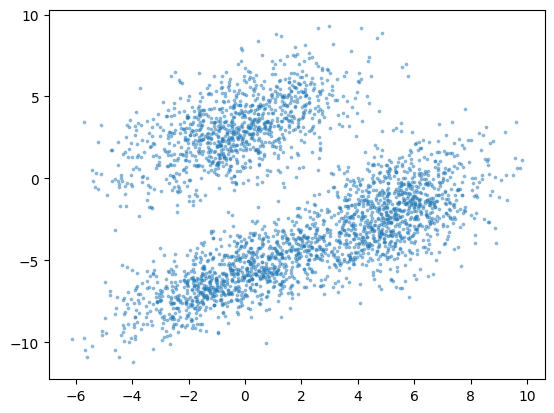

In [5]:
X = gen_data(k=3, dim=2, points_per_cluster=1000)
print(X.shape)

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print(kmeans.labels_)
centers = kmeans.cluster_centers_

[2 2 0 ... 0 0 0]


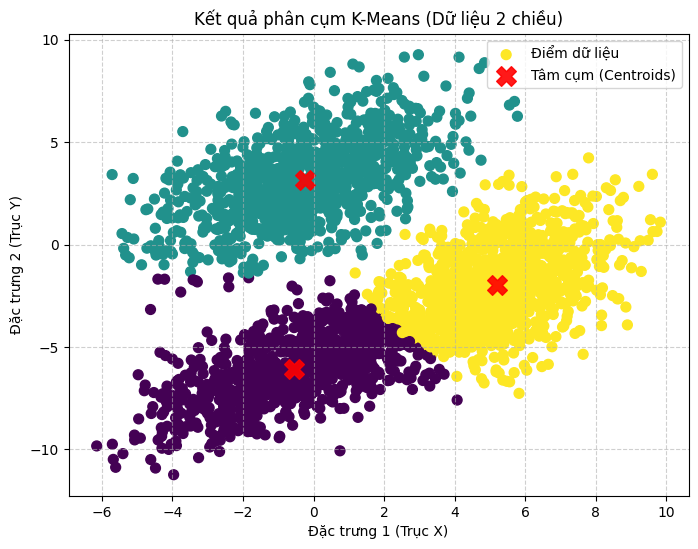

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', label='Điểm dữ liệu')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X', label='Tâm cụm (Centroids)')

plt.title("Kết quả phân cụm K-Means (Dữ liệu 2 chiều)")
plt.xlabel("Đặc trưng 1 (Trục X)")
plt.ylabel("Đặc trưng 2 (Trục Y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


# Sử dụng thư viện sklearn

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

In [9]:
data = pd.read_csv("/home/vitquay1708/Study_Space/ml/week_11/data/shopping-data.csv",header=0,index_col=0)

print(data.shape)
data.head()
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(200, 4)
(200, 2)


In [10]:
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


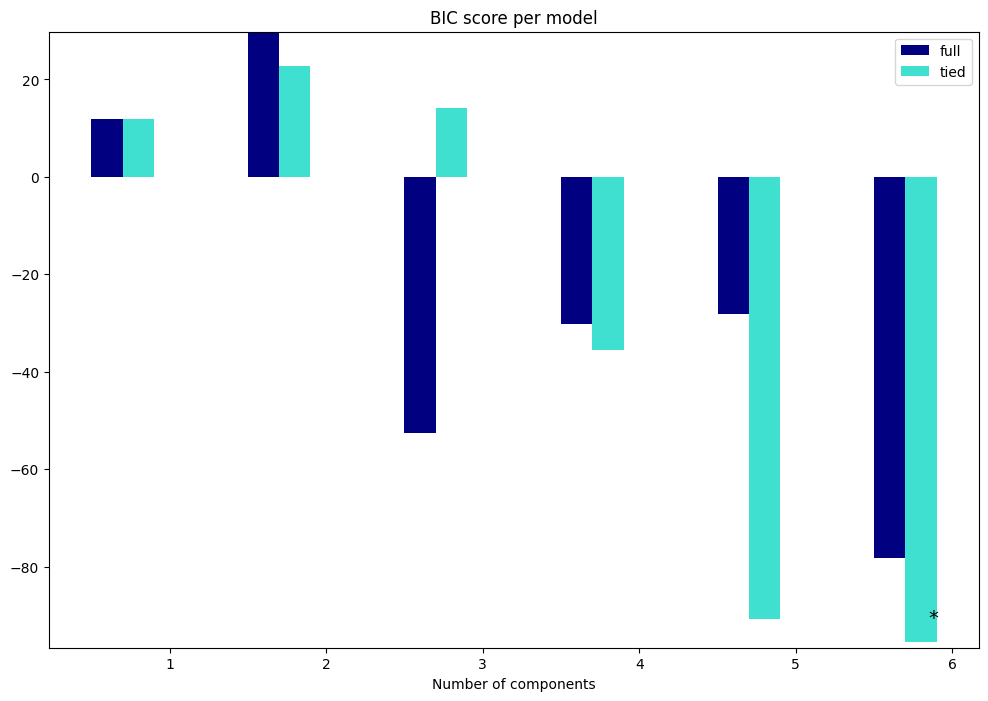

In [11]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
  for n_components in n_components_range:
    # Fit Gaussian mixture theo phương pháp huấn luyện EM
    gmm = GaussianMixture(n_components=n_components,
    covariance_type=cv_type)
    gmm.fit(X_std)
    bic.append(gmm.bic(X_std))
    # Gán model có BIC scores thấp nhất là model tốt nhất
    if bic[-1] < lowest_bic:
      lowest_bic = bic[-1]
      best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []
# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
  xpos = np.array(n_components_range) + .2 * (i - 2)
  bars.append(plt.bar(xpos, bic[i * len(n_components_range):
  (i + 1) * len(n_components_range)],
  width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

In [12]:
def _plot_kmean_scatter(X, labels):
  '''
  X: dữ liệu đầu vào
  labels: nhãn dự báo
  '''
  # lựa chọn màu sắc
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette("hls", num_classes))
  # vẽ biểu đồ scatter
  fig = plt.figure(figsize=(12, 8))
  ax = plt.subplot()
  sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,

  c=palette[labels.astype(int)])

  # thêm nhãn cho mỗi cluster
  txts = []
  for i in range(num_classes):
  # Vẽ text tên cụm tại trung vị của mỗi cụm
    xtext, ytext = np.median(X[labels == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)

    txt.set_path_effects([
    PathEffects.Stroke(linewidth=5, foreground="w"),
    PathEffects.Normal()])
    txts.append(txt)
  plt.title('t-sne visualization')

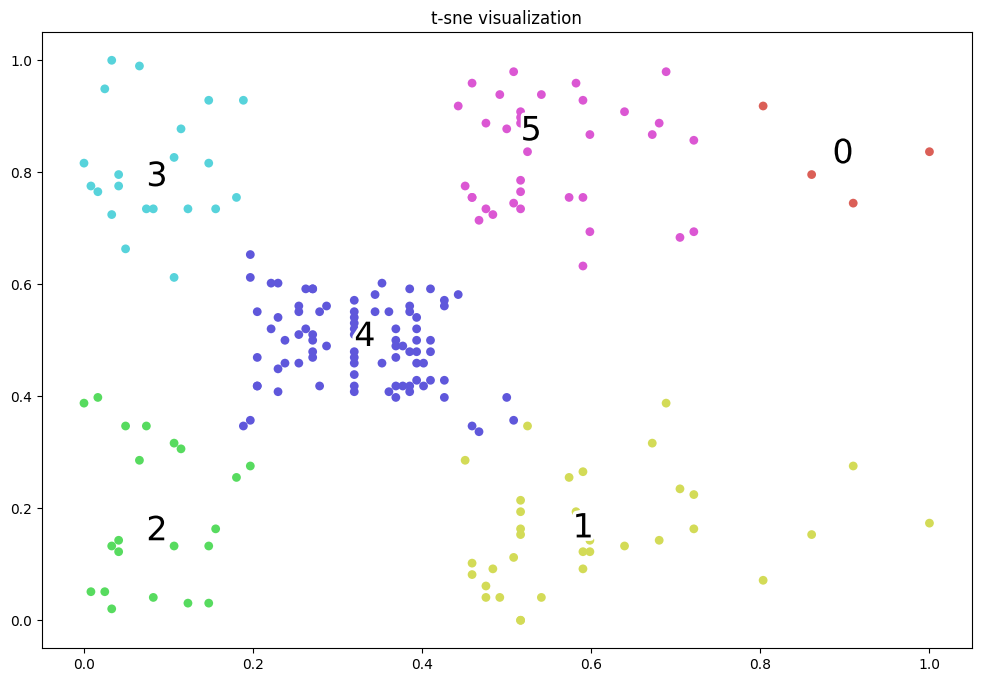

In [13]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

## Ví dụ mở rộng

In [14]:
from sklearn.decomposition import PCA

In [15]:
sales_data = pd.read_csv('/home/vitquay1708/Study_Space/ml/week_11/data/Sales_Transactions_Dataset_Weekly.csv')
print(sales_data.dtypes)
count = 0
X_sales = np.ones((sales_data.shape[0], 52))
i = 0
for col in sales_data.columns:
  if sales_data[col].dtype == 'float64':
    X_sales[:, i] = sales_data[col]
print(X.shape)

Product_Code      object
W0                 int64
W1                 int64
W2                 int64
W3                 int64
                  ...   
Normalized 47    float64
Normalized 48    float64
Normalized 49    float64
Normalized 50    float64
Normalized 51    float64
Length: 107, dtype: object
(200, 2)


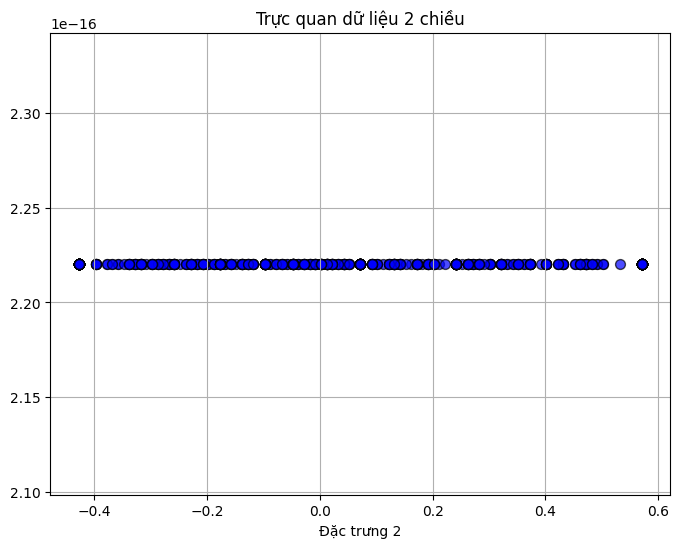

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sales)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolors='k', s = 50, alpha=0.7)
plt.title('Trực quan dữ liệu 2 chiều')
plt.xlabel('Đặc trưng 1')
plt.xlabel('Đặc trưng 2')
plt.grid(True)
plt.show()

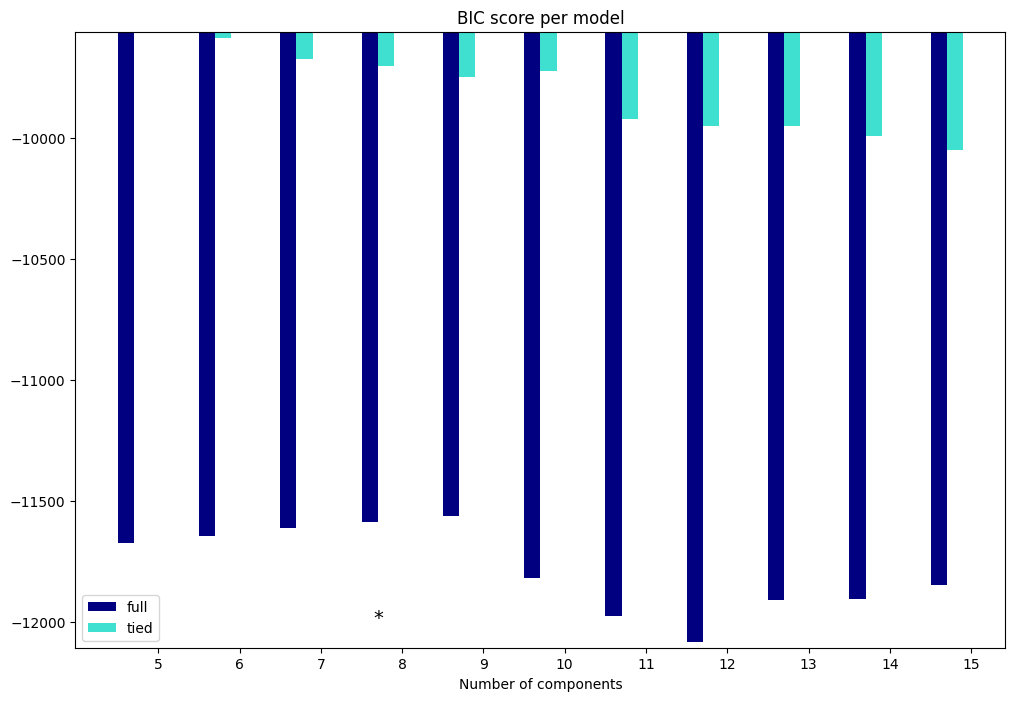

In [17]:
lowest_bic = np.inf
bic = []
n_components_range = range(5, 16)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
  for n_components in n_components_range:
    # Fit Gaussian mixture theo phương pháp huấn luyện EM
    gmm = GaussianMixture(n_components=n_components,
    covariance_type=cv_type)
    gmm.fit(X_pca)
    bic.append(gmm.bic(X_pca))
    # Gán model có BIC scores thấp nhất là model tốt nhất
    if bic[-1] < lowest_bic:
      lowest_bic = bic[-1]
      best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []
# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
  xpos = np.array(n_components_range) + .2 * (i - 2)
  bars.append(plt.bar(xpos, bic[i * len(n_components_range):
  (i + 1) * len(n_components_range)],
  width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

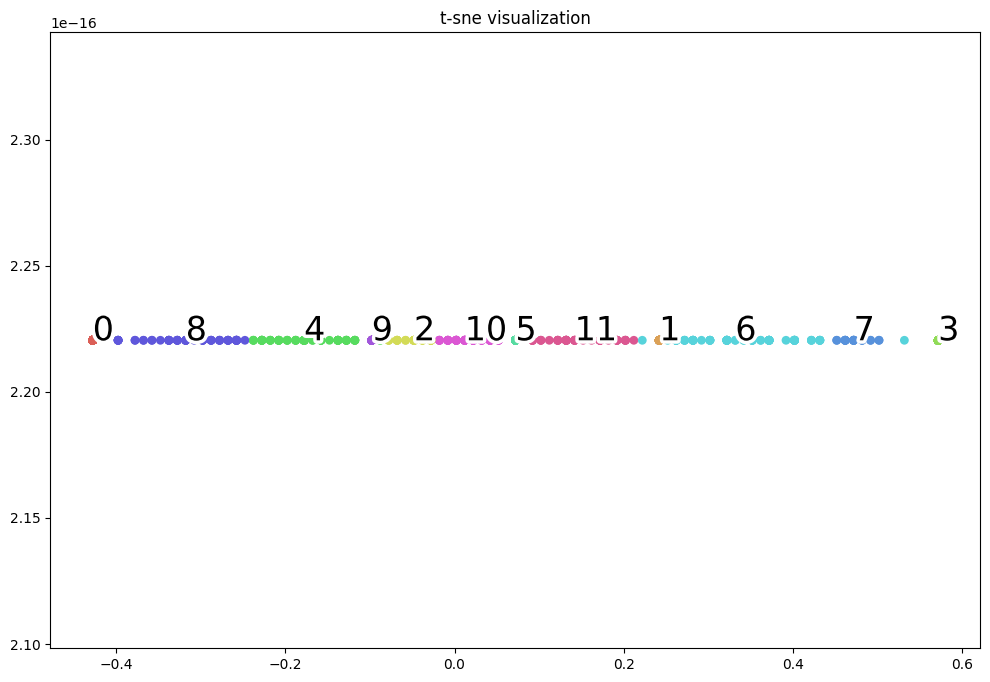

In [18]:
labels = best_gmm.predict(X_pca)
_plot_kmean_scatter(X_pca, labels)